In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns
from tqdm import tqdm

n = 500
m = 10000

M = np.diag(0.3 * np.ones(4)) + 0.7 * np.ones((4, 4))
mus = np.logspace(np.log10(0.001), np.log10(0.5), 20)  # Values of mu from 0 to 5
mus = np.insert(mus, 0, 0.0)

result1 = []
result2 = []
result3 = []
result4 = []

for mu in tqdm(mus):
    def perform_iteration(i):
        x_full = multivariate_normal(mean=np.zeros(4), cov=M).rvs(size=n + m)
        y_full = mu + x_full[:, 0] + x_full[:, 1] + 0.3 * np.random.normal(0, 1, size=n + m)
        
        # Split the data in half for training and testing
        n_half = n // 2
        m_half = m // 2

        x_unlabel = x_full[n:]
        x_label = x_full[:n]
        y_label = y_full[:n]

        x_label_1 = x_label[:n_half]
        x_label_2 = x_label[n_half:]
        y_label_1 = y_label[:n_half]
        y_label_2 = y_label[n_half:]
        x_unlabel_1 = x_unlabel[:m_half]
        x_unlabel_2 = x_unlabel[m_half:]

        dat1 = np.column_stack((x_label_1,))
        dat2 = np.column_stack((x_label_2,))

        model1 = sm.OLS(y_label_1, dat1).fit()
        model2 = sm.OLS(y_label_2, dat2).fit()

        model1NN = KNeighborsRegressor(n_neighbors=5)  # Use K-NN with 5 neighbors
        model2NN = KNeighborsRegressor(n_neighbors=5)

        model1NN.fit(dat1, y_label_1)
        model2NN.fit(dat2, y_label_2)

        x_label_1_f = np.column_stack((x_label_1,))
        x_label_2_f = np.column_stack((x_label_2,))
        x_unlabel_1_f = np.column_stack((x_unlabel_1,))
        x_unlabel_2_f = np.column_stack((x_unlabel_2,))

        fhat1 = model2.predict(x_label_1_f)
        fhat2 = model1.predict(x_label_2_f)
        fhat3 = model2.predict(x_unlabel_1_f)
        fhat4 = model1.predict(x_unlabel_2_f)

        fhat = np.concatenate((fhat1, fhat2, fhat3, fhat4))

        fhat1NN = model2NN.predict(x_label_1_f)
        fhat2NN = model1NN.predict(x_label_2_f)
        fhat3NN = model2NN.predict(x_unlabel_1_f)
        fhat4NN = model1NN.predict(x_unlabel_2_f)

        fhatNN = np.concatenate((fhat1NN, fhat2NN, fhat3NN, fhat4NN))

        delta = np.concatenate((np.ones(n), np.zeros(m)))

        S = np.sum(delta/n * y_full - delta/n * fhat + 1/(n+m) * fhat)
        D = np.sum((delta/n * y_full - delta/n * fhat + 1/(n+m) * fhat)**2)

        U_adapt_i = (n+m) / (n+m-1) * (S * S - D)

        S_NN = np.sum(delta/n * y_full - delta/n * fhatNN + 1/(n+m) * fhatNN)
        D_NN = np.sum((delta/n * y_full - delta/n * fhatNN + 1/(n+m) * fhatNN)**2)

        U_adapt_NN_i = (n+m) / (n+m-1) * (S_NN * S_NN - D_NN)
        Ybar_i = 1/n/(n-1) * ((np.sum(y_label))**2 - np.sum(y_label**2))

        gbar_label = mu * np.concatenate((fhat1, fhat2))
        gbar_full = mu * fhat
        U_SS_i = Ybar_i - 2 * np.mean(gbar_label) + 2 * np.mean(gbar_full)

        gbar_label_NN = mu * np.concatenate((fhat1NN, fhat2NN))
        gbar_full_NN = mu * fhatNN
        U_SS_NN_i = Ybar_i - 2 * np.mean(gbar_label_NN) + 2 * np.mean(gbar_full_NN)

        return U_adapt_i, Ybar_i, U_SS_i, U_adapt_NN_i, U_SS_NN_i

    results = Parallel(n_jobs=-1)(delayed(perform_iteration)(i) for i in range(50000))

    U_adapt, Ybar, U_SS, U_adapt_NN, U_SS_NN = zip(*results)

    baseline = np.mean((np.array(Ybar) - mu**2)**2)

    result1.append(baseline / np.mean((np.array(U_adapt) - mu**2)**2))
    result2.append(baseline / np.mean((np.array(U_SS) - mu**2)**2))
    result3.append(baseline / np.mean((np.array(U_adapt_NN) - mu**2)**2))
    result4.append(baseline / np.mean((np.array(U_SS_NN) - mu**2)**2))

100%|███████████████████████████████████████████| 21/21 [28:36<00:00, 81.75s/it]


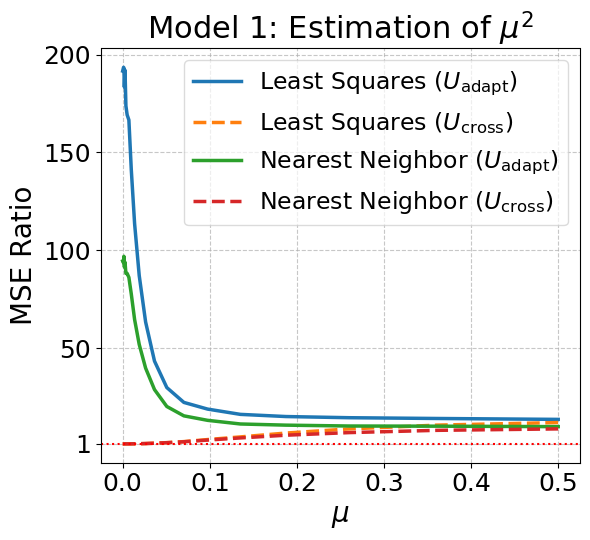

In [2]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create the figure with a specific aspect ratio
plt.figure(figsize=(6, 5.5))  # Adjust figure size as needed

# Use consistent line styles and colors
plt.plot(mus, result1, label='Least Squares ($U_{\\mathrm{adapt}}$)', linewidth=2.5, linestyle='-', color=custom_palette[0])
plt.plot(mus, result2, label='Least Squares ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='--', color=custom_palette[1])
plt.plot(mus, result3, label='Nearest Neighbor ($U_{\\mathrm{adapt}}$)', linewidth=2.5, linestyle='-', color=custom_palette[2])
plt.plot(mus, result4, label='Nearest Neighbor ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='--', color=custom_palette[3])

plt.xlabel(r'$\mu$', fontsize=20)
plt.ylabel('MSE Ratio', fontsize=20)
plt.title('Model 1: Estimation of $\\mu^2$', fontsize=22)  # Add a title

# Adjust the legend
legend = plt.legend(fontsize=17, loc='upper right')  # Add a title and adjust location
legend.get_title().set_fontsize(20)  # Increase the title fontsize
legend.get_frame().set_alpha(0.7)  # Make the legend background transparent
legend.get_frame().set_facecolor('white')  # Set a white background

# Set y-axis ticks starting at y=1 with appropriate increments
plt.axhline(y=1, color='red', linestyle=':', label='Baseline at y=1')
plt.yticks([1, 50, 100, 150, 200], fontsize=18)
plt.xticks(fontsize=18)

# Use a professional LaTeX font style
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure in high-resolution (e.g., PDF) for the research paper
plt.tight_layout()
plt.savefig('model1_mu2.pdf', format='pdf', dpi=300)

plt.show()